In [52]:
import sklearn.feature_extraction.text as sk_text

import json
import csv
import gc

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### Helper Function


In [53]:
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y})
    plt.figure(figsize=(20,10))
    if sort:
        t.sort_values(by=['y'],inplace=True)
    b = plt.plot(t['pred'].tolist(),label='prediction',color='b')
    a = plt.plot(t['y'].tolist(),label='expected',linewidth=3.0,color='r')
    plt.ylabel('output')
    plt.legend()
    plt.show()

### Convert business JSON to dataframe

In [54]:
#convert JSON business file to CSV
bus = pd.read_json('./yelp_dataset/yelp_academic_dataset_business.json', lines=True)
bus_toCSV = bus.to_csv('bussiness.csv', index = None)

business = pd.read_csv('bussiness.csv')

### Convert review JSON to dataframe

In [55]:
outfile = open("review_stars.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)

sfile.writerow(['business_id','stars', 'text'])
with open('./yelp_dataset/yelp_academic_dataset_review.json', encoding="utf-8") as f:     
    for line in f:
        row = json.loads(line)        # some special char must be encoded in 'utf-8'         
        sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])

outfile.close()
review= pd.read_csv('review_stars.tsv', delimiter ="\t", encoding="utf-8")

### Clean up business's dataframe

In [56]:
print("Before useless columns are dropped: \n{}".format(business.columns))
print("Shape before businesses with less than 20 reviews were dropped: {}\n".format(business.shape))

#drop business's useless column
business.drop('address', axis=1, inplace=True)
business.drop('postal_code', axis=1, inplace=True)
business.drop('latitude', axis=1, inplace=True)
business.drop('is_open', axis=1, inplace=True)
business.drop('hours', axis=1, inplace=True)
business.drop('attributes', axis=1, inplace=True)
business.drop('longitude', axis=1, inplace=True)
business.drop('city', axis=1, inplace=True)
business.drop('state', axis=1, inplace=True)
business.drop('categories', axis=1, inplace=True)

print("After useless columns are dropped: \n{}".format(business.columns))

#column rows that does not have more than 20 review count
business.drop(business[business['review_count'] < 20].index, inplace = True) 

print("Shape after businesses with less than 20 reviews were dropped: {}\n".format(business.shape))

#drop review count
business.drop('review_count', axis=1, inplace=True)


Before useless columns are dropped: 
Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')
Shape before businesses with less than 20 reviews were dropped: (209393, 14)

After useless columns are dropped: 
Index(['business_id', 'name', 'stars', 'review_count'], dtype='object')
Shape after businesses with less than 20 reviews were dropped: (66117, 4)



In [57]:
#observe business_df head
business.head()

,business_id,name,stars
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,3.5
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4.5
5,cKyLV5oWZJ2NudWgqs8VZw,Oasis Auto Center - Gilbert,4.5
6,oiAlXZPIFm2nBCt0DHLu_Q,Green World Cleaners,3.5
16,uZuh51lXu7tsrC8RAwkg1A,Manolo Blahnik,4.5


In [58]:
#observe review_df head
review.head()

,business_id,stars,text
0,-MhfebM0QIsKt87iDN-FNw,2.0,"b'As someone who has worked with many museums,..."
1,lbrU8StCq3yDfr-QMnGrmQ,1.0,b'I am actually horrified this place is still ...
2,HQl28KMwrEKHqhFrrDqVNQ,5.0,"b""I love Deagan's. I do. I really do. The atmo..."
3,5JxlZaqCnk1MnbgRirs40Q,1.0,"b'Dismal, lukewarm, defrosted-tasting ""TexMex""..."
4,IS4cv902ykd8wj1TR0N3-A,4.0,"b'Oh happy day, finally have a Canes near my c..."


### Merge review df and business df based on business_id column

In [59]:
yelp = pd.merge(review, business, on = 'business_id' )

In [60]:
#observe yelp_df head
yelp.head()

,business_id,stars_x,text,name,stars_y
0,-MhfebM0QIsKt87iDN-FNw,2.0,"b'As someone who has worked with many museums,...",Bellagio Gallery of Fine Art,3.5
1,-MhfebM0QIsKt87iDN-FNw,2.0,b'I have been there. I believe more than once....,Bellagio Gallery of Fine Art,3.5
2,-MhfebM0QIsKt87iDN-FNw,3.0,"b""I haven't been to Las Vegas in about 15 year...",Bellagio Gallery of Fine Art,3.5
3,-MhfebM0QIsKt87iDN-FNw,2.0,"b""One of the few places in town you can view w...",Bellagio Gallery of Fine Art,3.5
4,-MhfebM0QIsKt87iDN-FNw,3.0,b'This is a hard one to review. I was excited ...,Bellagio Gallery of Fine Art,3.5


In [61]:
#drop individual review's rating (stars_x)
yelp.drop('stars_x', axis=1, inplace=True)

#rename columns
yelp.rename(columns={'stars_y': 'rating', 'text': 'review'}, inplace = True)

#observe yelp_df head
yelp.head()

,business_id,review,name,rating
0,-MhfebM0QIsKt87iDN-FNw,"b'As someone who has worked with many museums,...",Bellagio Gallery of Fine Art,3.5
1,-MhfebM0QIsKt87iDN-FNw,b'I have been there. I believe more than once....,Bellagio Gallery of Fine Art,3.5
2,-MhfebM0QIsKt87iDN-FNw,"b""I haven't been to Las Vegas in about 15 year...",Bellagio Gallery of Fine Art,3.5
3,-MhfebM0QIsKt87iDN-FNw,"b""One of the few places in town you can view w...",Bellagio Gallery of Fine Art,3.5
4,-MhfebM0QIsKt87iDN-FNw,b'This is a hard one to review. I was excited ...,Bellagio Gallery of Fine Art,3.5


In [62]:
yelp_review_agg = yelp.groupby( ['business_id', 'name', 'rating'] )['review'].sum().reset_index()

#observe yelp_review_agg type
type(yelp_review_agg)

pandas.core.frame.DataFrame

In [63]:
yelp_review_agg.head()

,business_id,name,rating,review
0,--1UhMGODdWsrMastO9DZw,The Spicy Amigos,4.0,b'If you are looking for authentic Mexican str...
1,--6MefnULPED_I942VcFNA,John's Chinese BBQ Restaurant,3.0,"b""The bbq pork is very juicy and I only come h..."
2,--7zmmkVg-IMGaXbuVd0SQ,Primal Brewery,4.0,"b""I'm a tad reluctant to write a review as I r..."
3,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,4.0,"b""On yelp 5 stars = Woohoo! as good as it gets..."
4,--DaPTJW3-tB1vP-PfdTEg,Sunnyside Grill,4.0,"b""I used to come to this restaurant about two ..."


### TD-IDF representation for each business

In [64]:
vectorizer = TfidfVectorizer(
    stop_words = 'english',
    max_features = 3000,
    min_df = 0.05, # appearing less than 5% of documents
    max_df = 0.95 # appearing more than 95% of documents
)

matrix = vectorizer.fit_transform(yelp_review_agg['review'])

In [65]:
#review column no longer needed
yelp_review_agg.drop('review', axis=1, inplace=True)

### Merge TD-IDF Matrxi with help_review_agg

In [66]:
#turn TD-IDF matrix into Pandas Dataframe
tdidf_df = pd.DataFrame(data=matrix.toarray(), columns=["_" + i for i in vectorizer.get_feature_names()])

#merge yelp_review_agg and tdidf df
df_ready = yelp_review_agg.join(tdidf_df)

#clear intermediate variables to save memory
x = None
tdidf_df = None

#observe first five values of final df
df_ready.head()

,business_id,name,rating,_00,_000,_10,_100,_10pm,_11,_12,...,_yes,_yesterday,_yogurt,_york,_young,_younger,_yum,_yummy,_zero,_zucchini
0,--1UhMGODdWsrMastO9DZw,The Spicy Amigos,4.0,0.000000,0.000000,0.007810,0.000000,0.000000,0.024451,0.043853,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013887,0.0
1,--6MefnULPED_I942VcFNA,John's Chinese BBQ Restaurant,3.0,0.022285,0.000000,0.011986,0.000000,0.000000,0.014071,0.008412,...,0.011289,0.009886,0.000000,0.000000,0.000000,0.000000,0.005907,0.000000,0.000000,0.0
2,--7zmmkVg-IMGaXbuVd0SQ,Primal Brewery,4.0,0.000000,0.000000,0.012115,0.000000,0.000000,0.000000,0.011338,...,0.015214,0.006662,0.000000,0.000000,0.018565,0.010266,0.000000,0.000000,0.000000,0.0
3,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,4.0,0.005520,0.001115,0.013255,0.009863,0.001489,0.005187,0.005768,...,0.014481,0.000437,0.000000,0.017781,0.002234,0.001011,0.010974,0.014738,0.001414,0.0
4,--DaPTJW3-tB1vP-PfdTEg,Sunnyside Grill,4.0,0.000000,0.000000,0.029028,0.000000,0.000000,0.009087,0.008149,...,0.014581,0.000000,0.069207,0.000000,0.000000,0.000000,0.000000,0.009493,0.000000,0.0


### Obtain input feature

In [67]:
X = df_ready.drop(['business_id', 'name', 'rating'], axis = 1, inplace = False)
X.head()

,_00,_000,_10,_100,_10pm,_11,_12,_13,_14,_15,...,_yes,_yesterday,_yogurt,_york,_young,_younger,_yum,_yummy,_zero,_zucchini
0,0.000000,0.000000,0.007810,0.000000,0.000000,0.024451,0.043853,0.015365,0.000000,0.009131,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013887,0.0
1,0.022285,0.000000,0.011986,0.000000,0.000000,0.014071,0.008412,0.000000,0.000000,0.017517,...,0.011289,0.009886,0.000000,0.000000,0.000000,0.000000,0.005907,0.000000,0.000000,0.0
2,0.000000,0.000000,0.012115,0.000000,0.000000,0.000000,0.011338,0.000000,0.000000,0.004721,...,0.015214,0.006662,0.000000,0.000000,0.018565,0.010266,0.000000,0.000000,0.000000,0.0
3,0.005520,0.001115,0.013255,0.009863,0.001489,0.005187,0.005768,0.002608,0.005606,0.007128,...,0.014481,0.000437,0.000000,0.017781,0.002234,0.001011,0.010974,0.014738,0.001414,0.0
4,0.000000,0.000000,0.029028,0.000000,0.000000,0.009087,0.008149,0.000000,0.000000,0.006788,...,0.014581,0.000000,0.069207,0.000000,0.000000,0.000000,0.000000,0.009493,0.000000,0.0


### Obtain target features

In [68]:
Y = df_ready['rating']
Y.head()

0    4.0
1    3.0
2    4.0
3    4.0
4    4.0
Name: rating, dtype: float64

### Split training and testing dataset, create model, add layers

In [82]:
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", monitor='val_loss', verbose=0, save_best_only=True) # save best model

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=45)

activations = ['relu', 'sigmoid','tanh']
optimizers = ['adam', 'sgd']
n1 = 32
n2 = 64
batch_size = 64

#other tested neuron sizes were: 64, 128, 256, and 512 which did not have a significant 
#impact on the RMSE score, same goes with different layer count

best_model = (float('inf'), None)


# go through all possible configurations
for activation in activations:
    for optimizer in optimizers:
        # log current model config
        print(f"""
        activation: {activation}
        optimizer: {optimizer}
        batch size: {batch_size}
        input layer neuron count: {n1}
        hidden layer neuron count: {n2}
        """)

        model = Sequential()
        model.add(Dense(n1, input_dim=X.shape[1], activation=activation)) 
        model.add(Dense(n2, activation=activation))
        model.add(Dense(1))

        model.compile(
            loss='mean_squared_error', 
            optimizer=optimizer

        )

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
        model.fit(
            x_train,
            y_train, 
            validation_data=(x_test,y_test),
            batch_size = batch_size,
            callbacks=[monitor, checkpointer],
            verbose=0,
            epochs=1000
        )

        pred = model.predict(x_test)
        score = np.sqrt(metrics.mean_squared_error(pred,y_test))

        # set new best model manually
        if score < best_model[0]:
            best_model = (score, model)

        print(f"RMSE: {score}")
    
print('Training finished...Loading the best model')  
print()

# take best model
model = best_model[1]


        activation: relu
        optimizer: adam
        batch size: 64
        input layer neuron count: 64
        hidden layer neuron count: 32
        
Epoch 00014: early stopping
RMSE: 0.2772915725484188

        activation: relu
        optimizer: sgd
        batch size: 64
        input layer neuron count: 64
        hidden layer neuron count: 32
        
Epoch 00047: early stopping
RMSE: 0.26892556043572696

        activation: sigmoid
        optimizer: adam
        batch size: 64
        input layer neuron count: 64
        hidden layer neuron count: 32
        
Epoch 00019: early stopping
RMSE: 0.2565103735458283

        activation: sigmoid
        optimizer: sgd
        batch size: 64
        input layer neuron count: 64
        hidden layer neuron count: 32
        
Epoch 00050: early stopping
RMSE: 0.34173786535948

        activation: tanh
        optimizer: adam
        batch size: 64
        input layer neuron count: 64
        hidden layer neuron count: 32
        


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=45)
model = Sequential()

model.add(Dense(15, input_dim=X.shape[1], activation='relu')) 
model.add(Dense(7,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit(x_train,y_train, validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)


### Bar graph representation of each models RMSE score 

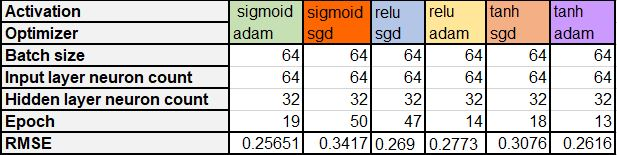

In [1]:
#Import library
from IPython.display import Image

# Load image from local storage
Image(filename = "yelp_table.JPG", width = 600, height = 300)

### Predict and calculate MSE score

$ \text{MSE} = \frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2 $

In [83]:
#predict
pred = model.predict(x_test)

#measure MSE error.  
score = metrics.mean_squared_error(pred, y_test)
print("Final score (MSE): {}".format(score))

Final score (MSE): 0.06579757173662036


### Predict and calculate RMSE score
$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2} $

In [84]:
#predict
pred = model.predict(x_test)

# Measure RMSE error
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

Score (RMSE): 0.2565103735458283


### Plot Lift Chart

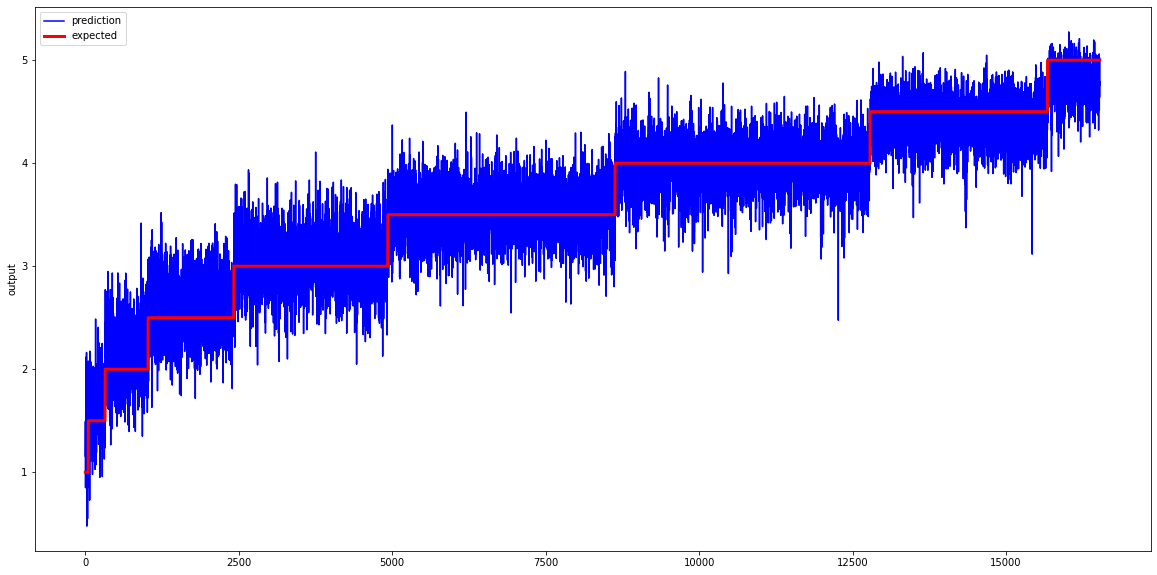

In [85]:
chart_regression(
    pred.flatten(),
    y_test,
    sort = True
)

### Test four random businesses

In [86]:
test_bus = [264,4752,3948,800]
res = []
for test_business in test_bus:
    tdidf = X.loc[test_business]
    prediction = model.predict(np.array([tdidf,]))
    truth = yelp_review_agg["rating"].iloc[test_business]
    res.append([
        yelp_review_agg["name"].iloc[test_business],
        prediction,
        truth,
        np.absolute(prediction - truth)
    ])
    
res = pd.DataFrame(res)
res.columns = ["Business Name", "Predicted Rating", "True Rating", "Distance"]
res

,Business Name,Predicted Rating,True Rating,Distance
0,Safelite AutoGlass,[[2.2481394]],2.5,[[0.25186062]]
1,Jardin Iwaki,[[4.615237]],4.5,[[0.115237236]]
2,The Caribbean Queen of Patties,[[3.1057417]],3.5,[[0.39425826]]
3,The Maharaja,[[4.0483947]],4.0,[[0.04839468]]
